# Saccades Project - Data munging and exploratory analysis

This notebook illustrates the data munging and cleaning processes I did using python to create a combined dataset from a set of distributed participant files containing eye movements collected in a lab for neuroscience research. 

### More info:
The data utilised in this project is the result of combined experiment datasets that were collected over three separate experiments for my PhD research. In all of the experiments, participants were required to perform a prosaccade and antisaccade eye movement task before and after a drug intervention. The prosaccade and antisaccade task paradigms were kept the same across the experiments. For an in-depth description of task parameters and experimental protocols, see the methods section of the following papers:

- [Connell, CJW. et al (2017) Fatigue-related impairments in oculomotor control are prevented by norepinephrine-dopamine reuptake inhibition. *Scientific Reports* 7; 42726. doi: 10.1038/srep42726](https://www.nature.com/articles/srep42726?WT.feed_name=subjects_neuroscience)

- [Connell, CJW. et al (2017) Caffeine increases the velocity of rapid eye movements in unfatigued humans. *Psychopharmacology*; 234(15): 2311-2323. doi: 10.1007/s00213-017-4638-1](https://www.researchgate.net/publication/317187946_Caffeine_increases_the_velocity_of_rapid_eye_movements_in_unfatigued_humans)

- [Connell, CJW. et al (2017) Effects of dopamine and norepinephrine on exercise-induced oculomotor fatigue. *Medicine and Science in Sports & Exercise*; 49(9), 1778-1788. doi: 10.1249/MSS.0000000000001307](https://www.researchgate.net/publication/316570236_Effects_of_Dopamine_and_Norepinephrine_on_Exercise-induced_Oculomotor_Fatigue)

## Combining experimental datasets

The first step was to combine the prosaccade and antisaccade data from the participant excel files for all of the experiments. These files were distributed across a bunch of file directories, and each file contained several sheets (sometimes messy) that contained relevant data and experimental parameters that needed to be extracted and recombined into a single dataframe for each participant.

In [31]:
# import relevant packages

import pandas as pd
import tkinter as tk
import numpy as np
from os import listdir
from os.path import isfile, join
from tkinter import filedialog

In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Thu Sep 21 09:50:18 2017
@author: Charlie
Prompts user to select a participant saccade file, imports all the sheets and
extracts experiment information, eye movement type, saccade measurement parameters
and combines these into a summary participant data frame which is exported into
a common directory to later be processed by combineSaccadeFiles.py
"""

# obtain the filepath of the excel sheet to be imported

root = tk.Tk()
root.withdraw()
file_path = filedialog.askopenfilename()

# extract eye movement type, experiment name & subjectID and store in list

participant_details = []

def DetermineEyeMovement(file_path):
	"""returns the type of eye movement that is being extracted from the excel spread sheet"""	

	if 'Prosaccade' in file_path:
		participant_details.append('Prosaccade')
	elif 'Antisaccade' in file_path:
		participant_details.append('Antisaccade')
	else:
		print ('file does not appear to contain Prosaccades or Antisaccades')

DetermineEyeMovement(file_path)
filename = file_path[file_path.find(participant_details[0]):]
filename = filename.replace('.xlsx', '')
filename_sep = filename.split('_')
participant_details.append(filename_sep[1])
participant_details.append(filename_sep[2])
details_keys = ['saccade_type', 'subjectID', 'experiment']
participant_details = dict(zip(details_keys, participant_details))
participant_details['experiment'] = participant_details['experiment'].lower()
subjectID = participant_details['subjectID']
saccade_type = participant_details['saccade_type'] 


# derive info from the sheet that has info on the camera used for each trial

info_df = pd.read_excel(file_path, sheetname='Data Check', parse_cols='G:N', skip_footer= 80)
info_df = info_df.dropna(how='all',axis=1)
info_df = info_df.dropna(how='all',axis=0)
info_df = info_df[3:]
if 'crave' in participant_details['experiment']:
    info_df.columns = ['camera', participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b']
    info_df.set_index(['camera'])
    tidyinfo_df = pd.melt(frame=info_df, id_vars='camera', value_vars=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b'], value_name='used')
else:
    info_df.columns = ['camera', participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b', participant_details['subjectID'] +'3a', participant_details['subjectID'] +'3b']
    info_df.set_index(['camera'])
    tidyinfo_df = pd.melt(frame=info_df, id_vars='camera', value_vars=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b', participant_details['subjectID'] +'3a', participant_details['subjectID'] +'3b'], value_name='used')
    
tidyinfo_df['subjectID'] = tidyinfo_df.variable.str[0:3]
tidyinfo_df['timepoint'] = tidyinfo_df.variable.str[3:]
tidyinfo_df['trial_number'] = tidyinfo_df.timepoint.str[0]
tidyinfo_df['time'] = tidyinfo_df.timepoint.str[1]
del tidyinfo_df['variable']
del tidyinfo_df['timepoint']
cameras_used = tidyinfo_df['used'] == 1
tidyinfo_df = tidyinfo_df[cameras_used]

# derive info from the sheet that has info on the intervention order for each trial

intervention_info = pd.read_excel(file_path, sheetname='Participant Summary - EXPORT', parse_cols='C:G', skip_footer=135)
intervention_info = intervention_info.dropna(how='all',axis=1)
intervention_info = intervention_info.dropna(how='all',axis=0)
intervention_info = intervention_info.drop(intervention_info.index[0])
intervention_info = intervention_info[0:3]
intervention_info = intervention_info.dropna(how='all',axis=1)
intervention_info = intervention_info.dropna(how='all',axis=0)
intervention_info.columns = ['Trial', 'Intervention']
intervention_info = pd.melt(frame=intervention_info, id_vars='Intervention', value_name= 'trial_number')
del intervention_info['variable']
intervention_info['trial_number'] = intervention_info['trial_number'].str.findall('\d')
intervention_info['trial_number'] = intervention_info.trial_number.str[-1]

# merge camera info, intervention info and participant details to get full picture of experimental parameters

experiment_info = pd.merge(left=tidyinfo_df, right=intervention_info, on='trial_number')
experiment_info['experiment'] = participant_details['experiment']
experiment_info['saccade_type'] = participant_details['saccade_type']
experiment_info['camera'] = experiment_info.camera.str[-1]
which_camera = {'A': 'A', 'B' : 'B', 'h': 'Both'}
experiment_info['collection_camera'] = experiment_info['camera'].map(which_camera)

# add in information about fatigue status

def status(q):
    if 'crave' in q['experiment']:
        return 'unfatigued'
    elif 'crave' not in q['experiment']:
        if q['time']== 'a':
            return 'unfatigued'
        elif q['time'] == 'b':
            return 'fatigued'

experiment_info['status'] = experiment_info.apply(status, axis=1)

# remove useless columns

del experiment_info['used']
del experiment_info['camera']
del which_camera

# extract experiment data as dictionary of pandas dataframes

if 'crave' in participant_details['experiment']:
    experiment_data = pd.read_excel(file_path, sheetname=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b'], parse_cols='A:AB', na_values = {' inf', ' Inf', 'Inf', 'inf'})
else:
    experiment_data = pd.read_excel(file_path, sheetname=[participant_details['subjectID'] +'1a', participant_details['subjectID'] +'1b', participant_details['subjectID'] +'2a', participant_details['subjectID'] +'2b', participant_details['subjectID'] +'3a', participant_details['subjectID'] +'3b'], parse_cols='A:AB', na_values = {' inf', ' Inf', 'Inf', 'inf'})

# label data correctly

for key, value in experiment_data.items(): 
	value['participant_info'] = key
	value['trial'] = value.participant_info.str[-2:-1]
	value['timepoint'] = value.participant_info.str[-1]
	value['subjectID'] = value.participant_info.str[0:3] 
	del value['participant_info']
	value.columns = [
            'Eye',
            'trial_presentation_number',
            'condition',
            'gap_overlap',
            'direction',
            'stimulus_onset_delay',
            'eye',
            'valid',
            'baselinex80%',
            'baselinex150-50ms',
            'post_saccade_position',
            'start_time',
            'end_time',
            'duration',
            'start_position',
            'end_position',
            'distance',
            'speed',
            'overshoot',
            'correct_direction',
            'speed_max',
            'speed_no_sign',
            'units_moved_in_saccade',
            'deg_moved_in_saccade',
            'deg_off_target_no_sign',
            'average_speed',
            'adjusted_latency',
            'latency_rule',
            'trial',
            'timepoint',
            'subjectID',
            ]


experiment_data = pd.concat(experiment_data)
experiment_data = experiment_data.merge(experiment_info, how='inner', left_on =['subjectID', 'trial', 'timepoint'], right_on =['subjectID', 'trial_number', 'time'])
del experiment_data['trial_number']
del experiment_data['time']
del experiment_data['eye']
del experiment_data['condition']


# filter the data based on the camera used for kinematic analysis

experiment_data = experiment_data[(experiment_data.collection_camera == experiment_data['Eye']) | (experiment_data.collection_camera == 'Both')]

# remove saccades deemed invalid by human analyser

experiment_data = experiment_data[(experiment_data['valid'] == 1)]
del experiment_data['valid']

# convert speed and max speed from eye tracker units to degrees

def convert_to_degrees(x):
    return x/0.037

experiment_data['AverageSpeed(deg/s)'] = experiment_data[['average_speed']].apply(convert_to_degrees)
experiment_data['MaxSpeed(deg/s)'] = experiment_data[['speed_max']].apply(convert_to_degrees)

# convert seconds to milliseconds

def convert_to_milliseconds(y):
    return y*1000

experiment_data['Duration(ms)'] = experiment_data[['duration']].apply(convert_to_milliseconds)
experiment_data['Latency(ms)'] = experiment_data[['adjusted_latency']].apply(convert_to_milliseconds)

# remove useless columns

del experiment_data['baselinex80%']
del experiment_data['baselinex150-50ms']
del experiment_data['distance']
del experiment_data['end_position']
del experiment_data['end_time']
del experiment_data['overshoot']
del experiment_data['post_saccade_position']
del experiment_data['start_position']
del experiment_data['start_time']
del experiment_data['stimulus_onset_delay']

# convert direction column to category

correct_direction = {1 : 'correct', 0: 'incorrect'}
experiment_data['correct_direction'] = experiment_data['correct_direction'].map(correct_direction)
del experiment_data['correct_direction']
del correct_direction

# convert latency_rule column to category (anticipatory saccade (i.e. latency < 70ms or normal saccade)
saccade_initiation = {1: 'normal', 0: 'anticipatory'}
experiment_data['saccade_initiation_type'] = experiment_data['latency_rule'].map(saccade_initiation)
del experiment_data['latency_rule']
del saccade_initiation


# set index of the experiment_data data frame

experiment_data['timepoint'] = experiment_data['timepoint'].astype('category')
experiment_data['saccade_type'] = experiment_data['saccade_type'].astype('category')
experiment_data['direction'] = experiment_data['direction'].astype('category') 
experiment_data['collection_camera'] = experiment_data['collection_camera'].astype('category')
experiment_data['gap_overlap'] = experiment_data['gap_overlap'].astype('category')
# experiment_data = experiment_data.set_index(['experiment', 'subjectID', 'Intervention', 'trial', 'timepoint', 'saccade_type', 'direction', 'collection_camera', 'gap_overlap'])

# export dataframe to csv file
export_path = 'C:/Users/ccon033/Dropbox/University/Charlotte/PhD-Experiments/Python-Projects/Saccades_data/'
export_filename = subjectID + '_' + saccade_type + '.csv'
export = export_path + export_filename
experiment_data.to_csv(export)


After repeating this for each participant, we can check the number of files in the export directory (there should be 74 files. One experiment had 13 participants, and two experiments had 12 participants with viable saccade files from both tasks: (13 + 24) X 2

In [14]:
justfiles = [f for f in listdir(export_path) if isfile(join(export_path, f))]
print(len(justfiles))

74


## Combining experimental datasets (cntd)
The second step was simply to import all the participant datasets contained in the export directory, combine them into a dataframe

In [29]:
export_path = '/Users/Charlie/Dropbox (Personal)/University/Charlotte/PhD-Experiments/Python-Projects/Saccades_data/'

In [48]:
# define the directory to look for the files in

directory = export_path
os.chdir(directory)

# obtain the list of files in the directory

filelist = [f for f in listdir(directory) if isfile(join(directory, f))]

# combine all files into one massive dataframe

saccades_df = pd.concat([pd.read_csv(f, index_col=0, header=0) for f in filelist],keys=filelist)

# rename columns
saccades_df = saccades_df[['gap_overlap', 'direction', 'trial',
                                     'timepoint', 'Intervention', 'experiment',
                                     'saccade_type', 'collection_camera', 'status',
                                     'AverageSpeed(deg/s)', 'MaxSpeed(deg/s)',
                                     'Duration(ms)', 'Latency(ms)', 
                                     'saccade_initiation_type', 'Eye',
                                     'trial_presentation_number', 'subjectID',
                                     'deg_moved_in_saccade']]

# swap out participant codes
participant_array = list(saccades_df.subjectID.unique())
participant_number = np.linspace(1, (len(participant_array)), num=(len(participant_array)))
code = dict(zip(participant_array, participant_number))
saccades_df['participant_num'] = saccades_df.loc[:,'subjectID'].map(code)
del saccades_df['subjectID']
saccades_df = saccades_df.set_index('participant_num')

Lets check out the dataset and check that everything looks ok:

In [49]:
saccades_df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 44595 entries, 1.0 to 36.0
Data columns (total 17 columns):
gap_overlap                  44595 non-null object
direction                    44595 non-null object
trial                        44595 non-null object
timepoint                    44595 non-null object
Intervention                 44595 non-null object
experiment                   44595 non-null object
saccade_type                 44595 non-null object
collection_camera            44595 non-null object
status                       44595 non-null object
AverageSpeed(deg/s)          44595 non-null float64
MaxSpeed(deg/s)              44542 non-null float64
Duration(ms)                 44595 non-null float64
Latency(ms)                  44595 non-null float64
saccade_initiation_type      44595 non-null object
Eye                          44595 non-null object
trial_presentation_number    44595 non-null float64
deg_moved_in_saccade         44595 non-null float64
dtypes: float64

In [50]:
# check that there isn't anything unexpected in the categorical variables in the dataset
print(pd.unique(saccades_df[['gap_overlap']].values.ravel()))
print(pd.unique(saccades_df[['direction']].values.ravel()))
print(pd.unique(saccades_df[['timepoint']].values.ravel()))
print(pd.unique(saccades_df[['Intervention']].values.ravel()))
print(pd.unique(saccades_df[['experiment']].values.ravel()))
print(pd.unique(saccades_df[['saccade_type']].values.ravel()))
print(pd.unique(saccades_df[['collection_camera']].values.ravel()))
print(pd.unique(saccades_df[['status']].values.ravel()))
print(pd.unique(saccades_df[['saccade_initiation_type']].values.ravel()))

[' overlap' ' gap']
[' left' ' right']
['a' 'b']
['Caffeine' 'Placebo' 'Bupropion' 'Methylphenidate' 'Reboxetine']
['CRaVe' 'CRaVE' 'crave' 'feeble' 'rave' 'masterrave']
['Antisaccade' 'Prosaccade']
['A' 'B' 'Both']
['unfatigued' 'fatigued']
['normal' 'anticipatory']


Looks like the experiment names have been read in funny - probably due to inconsistencies within the naming of the excel documents. 
The first three all refer to the same experiment, and the last two also refer to the same experiment.
Because of this error, its likely that 'fatigue' status will be incorrect for the 'crave' entries (there was no exercise in the crave experiment, so fatigue status should be 'unfatigued' for both timepoints. For the other experiments, fatigue status should be 'unfatigued' for timepoint 'b'.

In [51]:
boolean = (saccades_df['timepoint'] == 'b')& ((saccades_df['experiment'] == 'CRaVE') | 
                                          (saccades_df['experiment'] == 'CRaVe') | 
                                          (saccades_df['experiment'] == 'crave'))
saccades_df[boolean]

,gap_overlap,direction,trial,timepoint,Intervention,experiment,saccade_type,collection_camera,status,AverageSpeed(deg/s),MaxSpeed(deg/s),Duration(ms),Latency(ms),saccade_initiation_type,Eye,trial_presentation_number,deg_moved_in_saccade
participant_num,,,,,,,,,,,,,,,,,
1.0,overlap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,204.297297,520.621622,49.0,418.0,normal,A,1.0,10.189189
1.0,gap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,206.189189,548.135135,42.0,318.0,normal,A,2.0,8.405405
1.0,gap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,201.756757,338.432432,38.0,289.0,normal,A,3.0,7.756757
1.0,gap,right,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,197.891892,454.540541,45.0,288.0,normal,A,4.0,8.783784
1.0,gap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,172.540541,416.216216,42.0,283.0,normal,A,5.0,7.297297
1.0,overlap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,169.567568,410.540541,44.0,290.0,normal,A,6.0,7.459459
1.0,overlap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,219.891892,472.972973,37.0,247.0,normal,A,7.0,7.864865
1.0,gap,left,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,219.270270,405.405405,32.0,260.0,normal,A,8.0,7.216216
1.0,gap,right,1,b,Caffeine,CRaVe,Antisaccade,A,fatigued,178.675676,709.918919,48.0,267.0,normal,A,9.0,8.675676


Now that we know this, lets correct the experiment names and fatigue status

In [52]:
# unify experiment names (inconsistencies were from incorrectly named summary
# files)

def correct_experiment_names(y):
    if y == 'CRaVE':
        return 'crave'
    elif y == 'CRaVe':
        return 'crave'
    elif y == 'masterrave':
        return 'rave'
    else:
        return y

saccades_df['Experiment'] = saccades_df['experiment'].apply(correct_experiment_names)
del saccades_df['experiment']

# correct information about fatigue status

def crave_status(z):
    if 'crave' in z['Experiment']:
        return 'unfatigued'
    elif 'crave' not in z['Experiment']:
        if z['timepoint']== 'a':
            return 'unfatigued'
        elif z['timepoint'] == 'b':
            return 'fatigued'


saccades_df['status'] = saccades_df.apply(crave_status, axis=1)

# check that there isn't anything unexpected in the categorical variables in the dataset
print(pd.unique(saccades_df[['gap_overlap']].values.ravel()))
print(pd.unique(saccades_df[['direction']].values.ravel()))
print(pd.unique(saccades_df[['timepoint']].values.ravel()))
print(pd.unique(saccades_df[['Intervention']].values.ravel()))
print(pd.unique(saccades_df[['Experiment']].values.ravel()))
print(pd.unique(saccades_df[['saccade_type']].values.ravel()))
print(pd.unique(saccades_df[['collection_camera']].values.ravel()))
print(pd.unique(saccades_df[['status']].values.ravel()))
print(pd.unique(saccades_df[['saccade_initiation_type']].values.ravel()))

[' overlap' ' gap']
[' left' ' right']
['a' 'b']
['Caffeine' 'Placebo' 'Bupropion' 'Methylphenidate' 'Reboxetine']
['crave' 'feeble' 'rave']
['Antisaccade' 'Prosaccade']
['A' 'B' 'Both']
['unfatigued' 'fatigued']
['normal' 'anticipatory']


In [53]:
boolean_check = (saccades_df['timepoint'] == 'b')& (saccades_df['Experiment'] == 'crave')
saccades_df[boolean_check]

,gap_overlap,direction,trial,timepoint,Intervention,saccade_type,collection_camera,status,AverageSpeed(deg/s),MaxSpeed(deg/s),Duration(ms),Latency(ms),saccade_initiation_type,Eye,trial_presentation_number,deg_moved_in_saccade,Experiment
participant_num,,,,,,,,,,,,,,,,,
1.0,overlap,left,1,b,Caffeine,Antisaccade,A,unfatigued,204.297297,520.621622,49.0,418.0,normal,A,1.0,10.189189,crave
1.0,gap,left,1,b,Caffeine,Antisaccade,A,unfatigued,206.189189,548.135135,42.0,318.0,normal,A,2.0,8.405405,crave
1.0,gap,left,1,b,Caffeine,Antisaccade,A,unfatigued,201.756757,338.432432,38.0,289.0,normal,A,3.0,7.756757,crave
1.0,gap,right,1,b,Caffeine,Antisaccade,A,unfatigued,197.891892,454.540541,45.0,288.0,normal,A,4.0,8.783784,crave
1.0,gap,left,1,b,Caffeine,Antisaccade,A,unfatigued,172.540541,416.216216,42.0,283.0,normal,A,5.0,7.297297,crave
1.0,overlap,left,1,b,Caffeine,Antisaccade,A,unfatigued,169.567568,410.540541,44.0,290.0,normal,A,6.0,7.459459,crave
1.0,overlap,left,1,b,Caffeine,Antisaccade,A,unfatigued,219.891892,472.972973,37.0,247.0,normal,A,7.0,7.864865,crave
1.0,gap,left,1,b,Caffeine,Antisaccade,A,unfatigued,219.270270,405.405405,32.0,260.0,normal,A,8.0,7.216216,crave
1.0,gap,right,1,b,Caffeine,Antisaccade,A,unfatigued,178.675676,709.918919,48.0,267.0,normal,A,9.0,8.675676,crave


## Exploratory analysis and further cleaning
Now that we have combined the data into one dataframe, lets take a look at whether we have impossible values or outliers in measures of saccade latency, average speed, max speed and duration: 

In [58]:
# import visualization packages
import matplotlib.pyplot as plt
import seaborn as sns

# set seaborn style
sns.set_style("white")
sns.set_style("ticks")

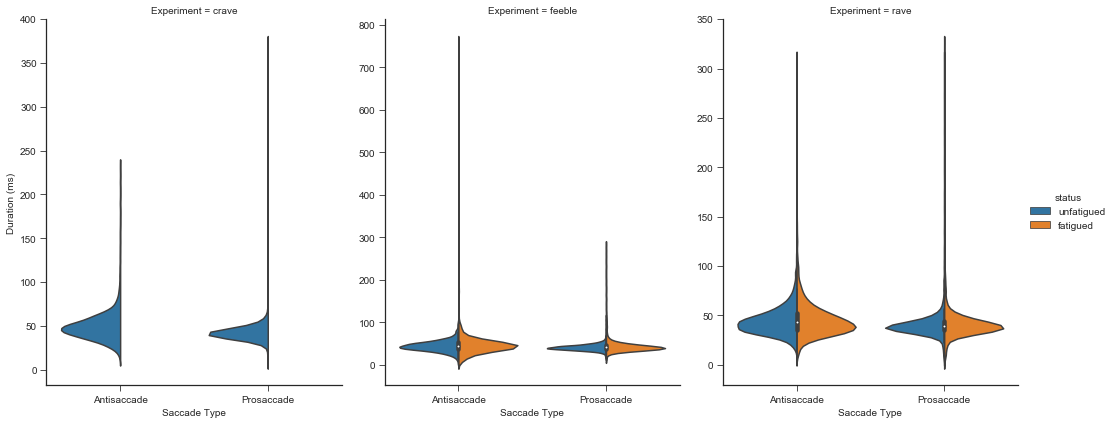

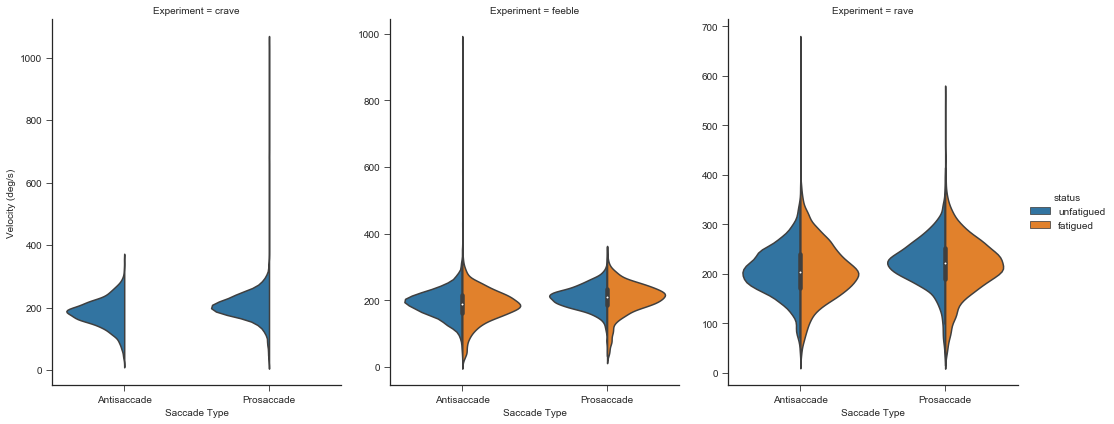

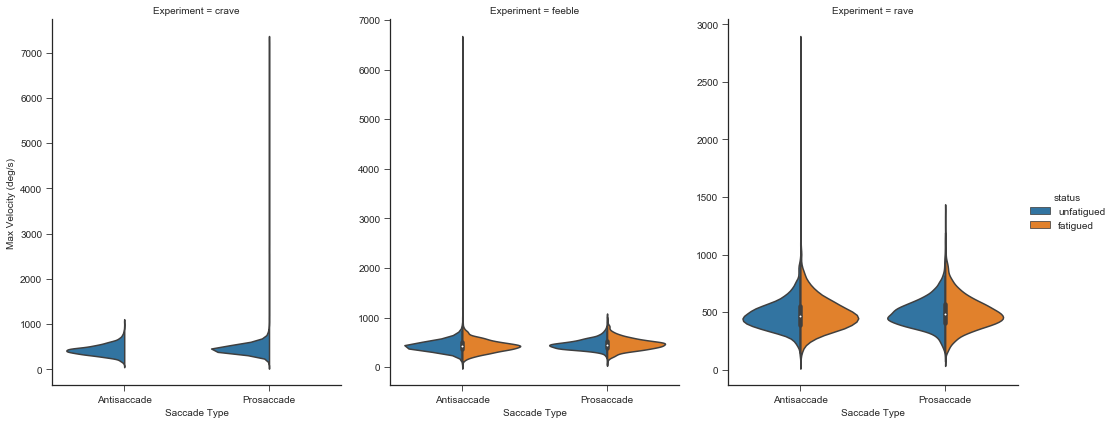

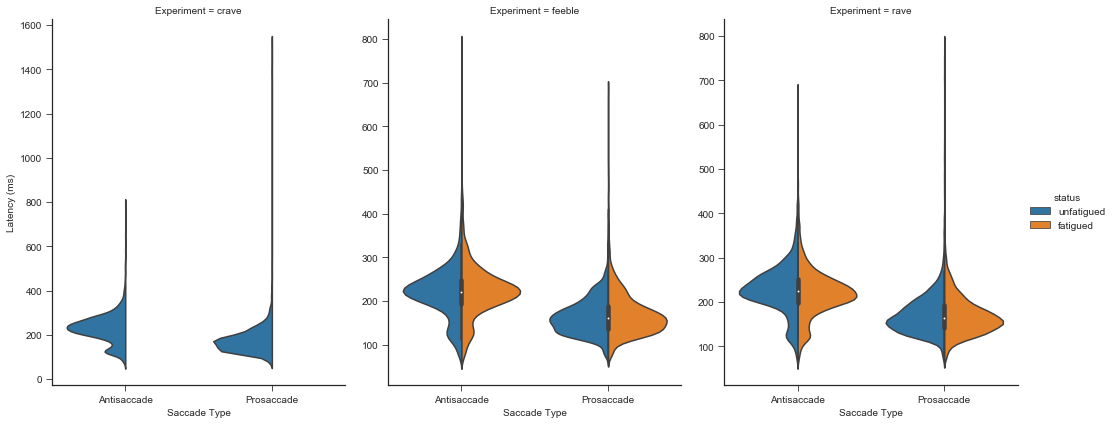

In [66]:
# Select subset of both Prosaccade and Antisaccades with normal initiation type (i.e. the saccade was not 
# anticipatory)
saccades_norm = saccades_df[saccades_df['saccade_initiation_type'] == 'normal']

# violin plot of the distribution of duration by experiment
duration = sns.factorplot(x='saccade_type', y='Duration(ms)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
duration.set_axis_labels('Saccade Type', 'Duration (ms)')
plt.show()

# violin plot of the distribution of average speed by experiment
av_speed = sns.factorplot(x='saccade_type', y='AverageSpeed(deg/s)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
av_speed.set_axis_labels('Saccade Type', 'Velocity (deg/s)')
plt.show()

# violin plot of the distribution of max speed by experiment
max_speed = sns.factorplot(x='saccade_type', y='MaxSpeed(deg/s)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
max_speed.set_axis_labels('Saccade Type', 'Max Velocity (deg/s)')
plt.show()

# violin plot of the distribution of latency by experiment
latency = sns.factorplot(x='saccade_type', y='Latency(ms)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
latency.set_axis_labels('Saccade Type', 'Latency (ms)')
plt.show()

We see that most measures have impossible values, probably due to measurement error or noise in the eye tracking trace. From visual inspection of the plots, it looks as though all measures have a unimodal distribution. Antisaccade latency is an exception though. A bimodal distribution for antisaccade latency is to be expected as the antisaccade task consisted of two conditions - 'gap' and 'overlap'. In 'gap' trials, the fixation point that participants were viewing would disappear before the appearance of the peripheral stimulus they were instructed to look at. Conversely, in the 'overlap' trials, the fixation point would remain throughout the trial. This has an interesting effect on visual attention - in gap trials visual attention is released from the fixation point before the target appears, so latency toward the targets in the gap condition often contain a subset of saccades termed 'express saccades'. If this is the case here then the distribution for overlap latency should look more unimodal (as it will have fewer 'express saccades', while the distribution for gap latency will maintain a more bimodal appearance. Lets explore this with another plot:

In [68]:
# Select subset of Antisaccades with normal initiation type (i.e. the saccade was not 
# anticipatory)
antisaccade_boolean = (saccades_df['saccade_initiation_type'] == 'normal') & (saccades_df['saccade_type'] == 'Antisaccade')
antisaccades = saccades_df[antisaccade_boolean]

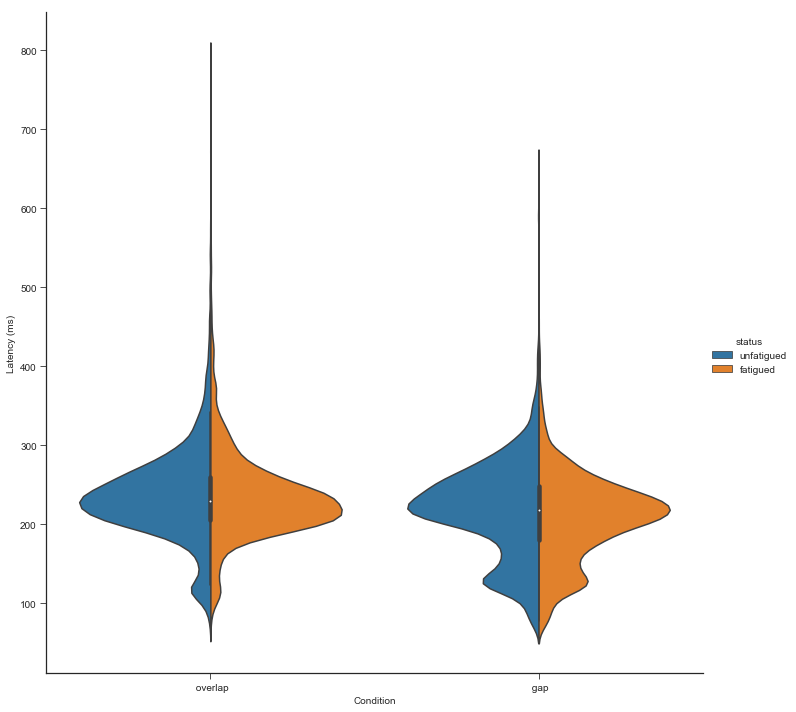

In [70]:
# violin plot of the distribution of antisaccade latency by condition
antisaccade_latency = sns.factorplot(x='gap_overlap', y='Latency(ms)',
                   hue='status', scale='width',
                   data=antisaccades, kind='violin', split=True,
                   size=10, aspect=1, sharey=False)
antisaccade_latency.set_axis_labels('Condition', 'Latency (ms)')
plt.show()

Alright - lets clean this dataset further by removing impossible values and outliers. I determined cutoff numbers by what is physiologically possible for the eyes to perform - this is to clear out data that is the result of noise from the eye tracker as opposed to a realistic measure of an eye movement. After implementing those cutoffs, outliers were defined as measures further than 3 standard deviations away from the mean and removed from the dataset:

In [72]:
# clean dataset further - remove outliers and impossible values. 
# cutoff numbers determined by what is physiologically possible
# outliers defined as those placed greater than 3 standard deviations away from the mean

saccades_clean = saccades_df[(saccades_df['Duration(ms)']>0) & 
                                     (saccades_df['Duration(ms)']< 600)
                                     & (saccades_df['deg_moved_in_saccade']>1)
                                     & (saccades_df['deg_moved_in_saccade']< 30)
                                     & (saccades_df['AverageSpeed(deg/s)']>0)
                                     & (saccades_df['AverageSpeed(deg/s)']< 1500)
                                     & (saccades_df['MaxSpeed(deg/s)']>0)
                                     & (saccades_df['MaxSpeed(deg/s)']< 2500)
                                     & (saccades_df['Latency(ms)']<1000)]
saccades_clean = saccades_clean[np.abs(saccades_clean['MaxSpeed(deg/s)']-saccades_clean['MaxSpeed(deg/s)'].mean())<=(3*saccades_clean['MaxSpeed(deg/s)'].std())]
saccades_clean = saccades_clean[np.abs(saccades_clean['Duration(ms)']-saccades_clean['Duration(ms)'].mean())<=(3*saccades_clean['Duration(ms)'].std())]
saccades_clean = saccades_clean[np.abs(saccades_clean['Latency(ms)']-saccades_clean['Latency(ms)'].mean())<=(3*saccades_clean['Latency(ms)'].std())]
saccades_clean = saccades_clean[np.abs(saccades_clean['AverageSpeed(deg/s)']-saccades_clean['AverageSpeed(deg/s)'].mean())<=(3*saccades_clean['AverageSpeed(deg/s)'].std())]
saccades_clean = saccades_clean[np.abs(saccades_clean['deg_moved_in_saccade']-saccades_clean['deg_moved_in_saccade'].mean())<=(3*saccades_clean['deg_moved_in_saccade'].std())]

Lets see what the data distributions look like now:

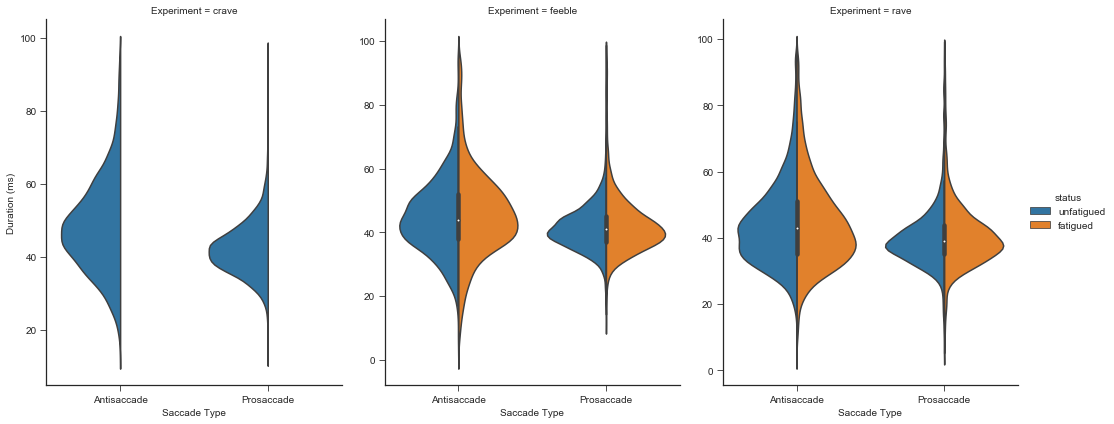

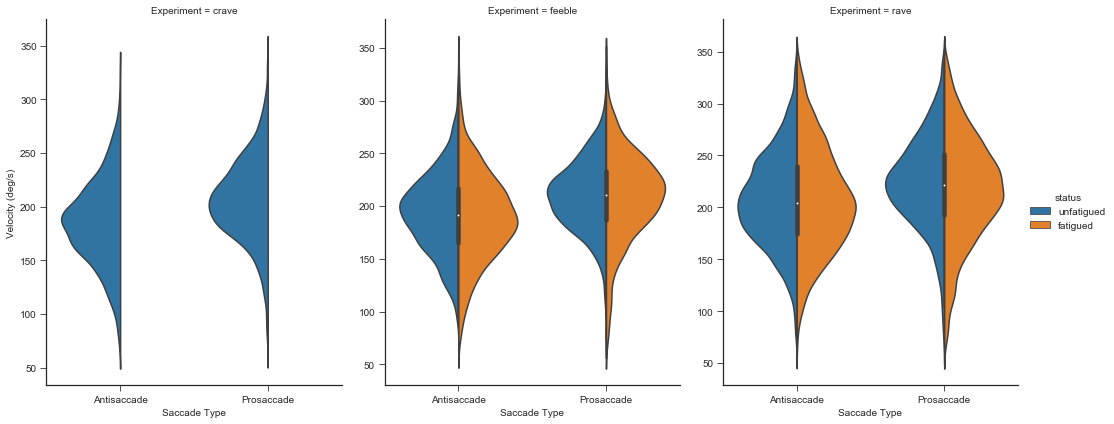

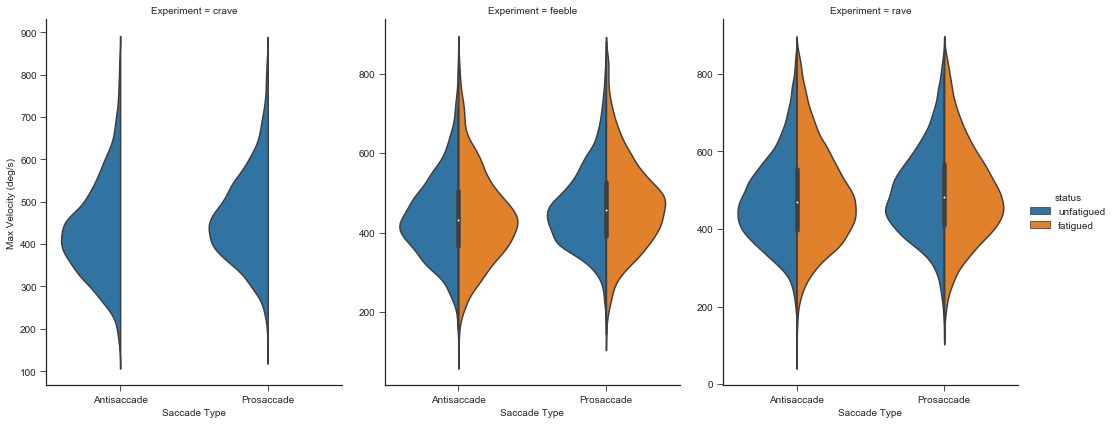

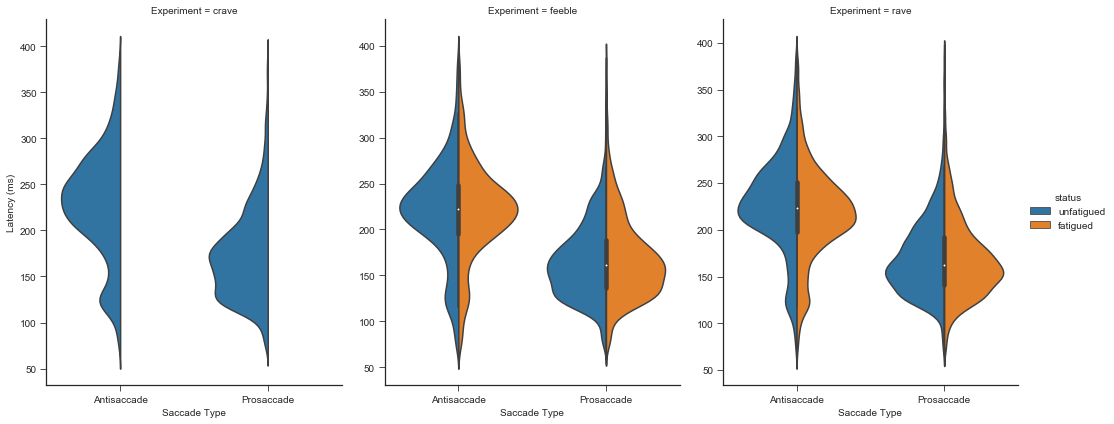

In [73]:
# Select subset of both Prosaccade and Antisaccades with normal initiation type (i.e. the saccade was not 
# anticipatory) now that the data has been cleaned
saccades_norm_clean = saccades_clean[saccades_clean['saccade_initiation_type'] == 'normal']

# violin plot of the distribution of duration by experiment
duration = sns.factorplot(x='saccade_type', y='Duration(ms)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm_clean, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
duration.set_axis_labels('Saccade Type', 'Duration (ms)')
plt.show()

# violin plot of the distribution of average speed by experiment
av_speed = sns.factorplot(x='saccade_type', y='AverageSpeed(deg/s)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm_clean, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
av_speed.set_axis_labels('Saccade Type', 'Velocity (deg/s)')
plt.show()

# violin plot of the distribution of max speed by experiment
max_speed = sns.factorplot(x='saccade_type', y='MaxSpeed(deg/s)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm_clean, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
max_speed.set_axis_labels('Saccade Type', 'Max Velocity (deg/s)')
plt.show()

# violin plot of the distribution of latency by experiment
latency = sns.factorplot(x='saccade_type', y='Latency(ms)',
                   hue='status', col='Experiment', scale='width',
                   data=saccades_norm_clean, kind='violin', split=True,
                   size=6, aspect=.8, sharey=False)
latency.set_axis_labels('Saccade Type', 'Latency (ms)')
plt.show()

Output of the 'cleaned' dataset, ready for further analysis

In [88]:
saccades_clean

,gap_overlap,direction,trial,timepoint,Intervention,saccade_type,collection_camera,status,AverageSpeed(deg/s),MaxSpeed(deg/s),Duration(ms),Latency(ms),saccade_initiation_type,Eye,trial_presentation_number,deg_moved_in_saccade,Experiment
participant_num,,,,,,,,,,,,,,,,,
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,208.702703,537.837838,44.0,273.0,normal,A,2.0,9.027027,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,198.918919,414.945946,40.0,286.0,normal,A,3.0,8.162162,crave
1.0,gap,right,1,a,Caffeine,Antisaccade,A,unfatigued,224.675676,548.486486,42.0,272.0,normal,A,4.0,8.918919,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,222.081081,418.135135,34.0,190.0,normal,A,5.0,7.567568,crave
1.0,overlap,left,1,a,Caffeine,Antisaccade,A,unfatigued,180.756757,601.810811,52.0,351.0,normal,A,6.0,9.378378,crave
1.0,overlap,left,1,a,Caffeine,Antisaccade,A,unfatigued,215.432432,472.972973,42.0,243.0,normal,A,7.0,8.810811,crave
1.0,gap,left,1,a,Caffeine,Antisaccade,A,unfatigued,199.297297,788.864865,47.0,235.0,normal,A,8.0,9.270270,crave
1.0,gap,right,1,a,Caffeine,Antisaccade,A,unfatigued,250.297297,427.918919,35.0,182.0,normal,A,9.0,8.675676,crave
1.0,overlap,right,1,a,Caffeine,Antisaccade,A,unfatigued,199.783784,389.378378,48.0,276.0,normal,A,10.0,9.675676,crave


In [92]:
# export the dataframe to .csv
file_path = '/Users/Charlie/Desktop/'
export_filename = 'saccades_clean.csv'
export = file_path + export_filename
saccades_clean.to_csv(export)